In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [3]:
os.listdir('/kaggle/input/soil-classification/soil_classification-2025/train')[:5]

['img_3c4ed833.jpeg',
 'img_8163dc71.jpg',
 'img_e48dfef4.jpg',
 'img_83d433d2.jpg',
 'img_4b62f891.jpeg']

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [5]:
train = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')

display(train.head())

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [6]:
le = LabelEncoder()
train["label_encoded"] = le.fit_transform(train["soil_type"])

In [7]:
display(train.head())

,image_id,soil_type,label_encoded
0,img_ed005410.jpg,Alluvial soil,0
1,img_0c5ecd2a.jpg,Alluvial soil,0
2,img_ed713bb5.jpg,Alluvial soil,0
3,img_12c58874.jpg,Alluvial soil,0
4,img_eff357af.jpg,Alluvial soil,0


In [8]:
train["label"] = train["soil_type"]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


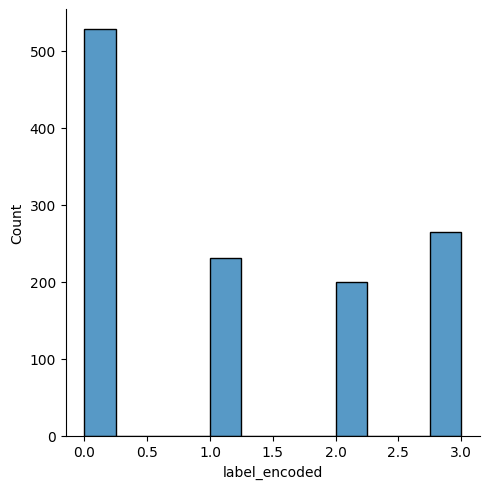

In [9]:
sns.displot(train['label_encoded'], kde=False)

In [10]:
train["soil_type"].value_counts()

soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

In [11]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '/kaggle/input/soil-classification/soil_classification-2025/train'
TEST_PATH = '/kaggle/input/soil-classification/soil_classification-2025/test'

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b3_ns'  #'resnext50_32x4d'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=4
    target_col='label_encoded'
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [13]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred,average='macro')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [15]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label_encoded
0     0                106
      1                 46
      2                 40
      3                 53
1     0                106
      1                 47
      2                 40
      3                 52
2     0                106
      1                 46
      2                 39
      3                 53
3     0                105
      1                 46
      2                 40
      3                 53
4     0                105
      1                 46
      2                 40
      3                 53
dtype: int64


In [16]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label_encoded'].values
        self.foldername = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        folder_name = self.foldername[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image_id']
        return image

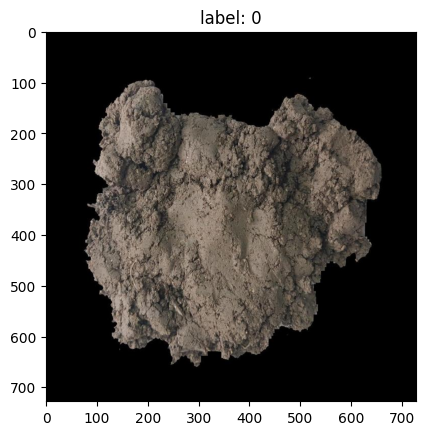

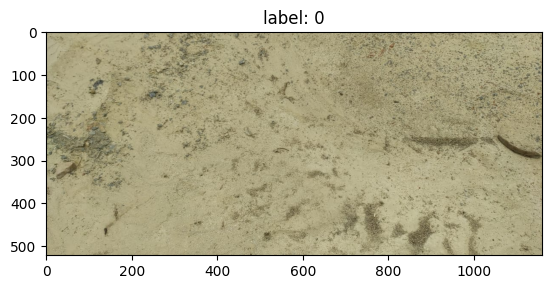

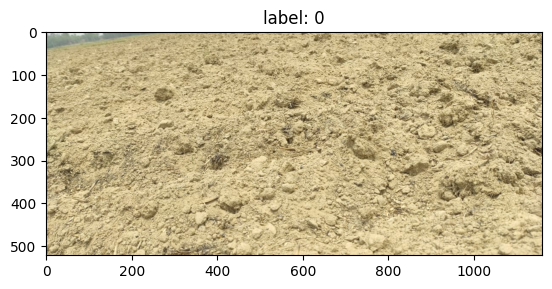

In [17]:
train_dataset = TrainDataset(train, transform=None)

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [18]:
CFG.size

512

In [19]:
from albumentations import Resize

In [20]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop((CFG.size, CFG.size)),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [21]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

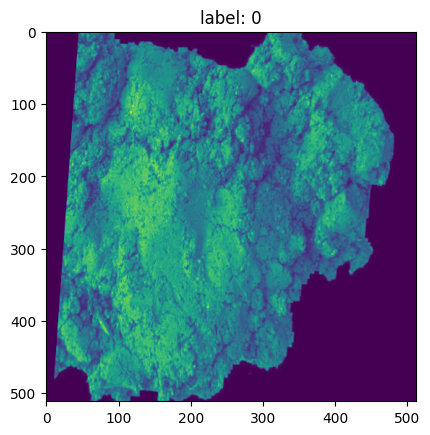

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [24]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0842,  0.0463, -0.0501, -0.0458],
        [ 0.0389,  0.0996, -0.0580, -0.1321],
        [ 0.0364,  0.0881, -0.0560, -0.1217],
        [ 0.1194,  0.0668,  0.1276, -0.0207]], grad_fn=<AddmmBackward0>)


In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [26]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - F1 SCORE: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth',weights_only = False)
    print( len(check_point['preds']))

    valid_folds[[str(c) for c in range(4)]] = check_point['preds']
    
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


In [27]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch: [1][0/61] Data 0.801 (0.801) Elapsed 0m 2s (remain 2m 48s) Loss: 1.4060(1.4060) Grad: 2.2280  
Epoch: [1][60/61] Data 0.000 (0.013) Elapsed 0m 45s (remain 0m 0s) Loss: 0.5340(0.7899) Grad: 3.0779  
EVAL: [0/16] Data 0.752 (0.752) Elapsed 0m 0s (remain 0m 14s) Loss: 0.1719(0.1719) 


Epoch 1 - avg_train_loss: 0.7899  avg_val_loss: 0.3600  time: 50s
Epoch 1 - F1 SCORE: 0.9001707788090159
Epoch 1 - Save Best Score: 0.9002 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1719(0.3600) 
Epoch: [2][0/61] Data 0.705 (0.705) Elapsed 0m 1s (remain 1m 3s) Loss: 0.2080(0.2080) Grad: 1.2441  
Epoch: [2][60/61] Data 0.000 (0.018) Elapsed 0m 47s (remain 0m 0s) Loss: 0.3097(0.3579) Grad: 1.9074  
EVAL: [0/16] Data 0.741 (0.741) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0943(0.0943) 


Epoch 2 - avg_train_loss: 0.3579  avg_val_loss: 0.2341  time: 52s
Epoch 2 - F1 SCORE: 0.9197133430812012
Epoch 2 - Save Best Score: 0.9197 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0084(0.2341) 
Epoch: [3][0/61] Data 1.035 (1.035) Elapsed 0m 1s (remain 1m 20s) Loss: 0.1957(0.1957) Grad: 1.6704  
Epoch: [3][60/61] Data 0.000 (0.025) Elapsed 0m 52s (remain 0m 0s) Loss: 0.2956(0.2721) Grad: 2.0533  
EVAL: [0/16] Data 0.736 (0.736) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0797(0.0797) 


Epoch 3 - avg_train_loss: 0.2721  avg_val_loss: 0.2183  time: 57s
Epoch 3 - F1 SCORE: 0.9200799106513702
Epoch 3 - Save Best Score: 0.9201 Model


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0806(0.2183) 
Epoch: [4][0/61] Data 0.664 (0.664) Elapsed 0m 0s (remain 0m 59s) Loss: 0.5294(0.5294) Grad: 3.7595  
Epoch: [4][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0412(0.2220) Grad: 0.5370  
EVAL: [0/16] Data 0.717 (0.717) Elapsed 0m 0s (remain 0m 13s) Loss: 0.0663(0.0663) 


Epoch 4 - avg_train_loss: 0.2220  avg_val_loss: 0.1823  time: 55s
Epoch 4 - F1 SCORE: 0.9550452929709895
Epoch 4 - Save Best Score: 0.9550 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0167(0.1823) 
Epoch: [5][0/61] Data 0.617 (0.617) Elapsed 0m 0s (remain 0m 56s) Loss: 0.1234(0.1234) Grad: 1.6811  
Epoch: [5][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0447(0.1829) Grad: 0.9369  
EVAL: [0/16] Data 0.753 (0.753) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0172(0.0172) 


Epoch 5 - avg_train_loss: 0.1829  avg_val_loss: 0.1665  time: 55s
Epoch 5 - F1 SCORE: 0.9496296916836076


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0239(0.1665) 
Epoch: [6][0/61] Data 0.613 (0.613) Elapsed 0m 0s (remain 0m 56s) Loss: 0.2584(0.2584) Grad: 2.7427  
Epoch: [6][60/61] Data 0.000 (0.018) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2205(0.1637) Grad: 2.4106  
EVAL: [0/16] Data 0.753 (0.753) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0315(0.0315) 


Epoch 6 - avg_train_loss: 0.1637  avg_val_loss: 0.1718  time: 55s
Epoch 6 - F1 SCORE: 0.9565091674195918
Epoch 6 - Save Best Score: 0.9565 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0553(0.1718) 
Epoch: [7][0/61] Data 0.747 (0.747) Elapsed 0m 1s (remain 1m 4s) Loss: 0.1496(0.1496) Grad: 1.9920  
Epoch: [7][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0715(0.1696) Grad: 2.0709  
EVAL: [0/16] Data 0.744 (0.744) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0212(0.0212) 


Epoch 7 - avg_train_loss: 0.1696  avg_val_loss: 0.1737  time: 56s
Epoch 7 - F1 SCORE: 0.9350190604732624


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0287(0.1737) 
Epoch: [8][0/61] Data 0.754 (0.754) Elapsed 0m 1s (remain 1m 9s) Loss: 0.1440(0.1440) Grad: 1.5409  
Epoch: [8][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0378(0.1221) Grad: 0.7561  
EVAL: [0/16] Data 0.841 (0.841) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0247(0.0247) 


Epoch 8 - avg_train_loss: 0.1221  avg_val_loss: 0.1836  time: 56s
Epoch 8 - F1 SCORE: 0.9321512642377772


EVAL: [15/16] Data 0.000 (0.053) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0750(0.1836) 
Epoch: [9][0/61] Data 0.674 (0.674) Elapsed 0m 1s (remain 1m 0s) Loss: 0.1766(0.1766) Grad: 2.2662  
Epoch: [9][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0810(0.1347) Grad: 1.5657  
EVAL: [0/16] Data 0.705 (0.705) Elapsed 0m 0s (remain 0m 13s) Loss: 0.0161(0.0161) 


Epoch 9 - avg_train_loss: 0.1347  avg_val_loss: 0.1623  time: 56s
Epoch 9 - F1 SCORE: 0.9518493279536135


EVAL: [15/16] Data 0.000 (0.044) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0523(0.1623) 
Epoch: [10][0/61] Data 0.770 (0.770) Elapsed 0m 1s (remain 1m 5s) Loss: 0.0243(0.0243) Grad: 0.5038  
Epoch: [10][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1581(0.1233) Grad: 2.2660  
EVAL: [0/16] Data 0.733 (0.733) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0151(0.0151) 


Epoch 10 - avg_train_loss: 0.1233  avg_val_loss: 0.1583  time: 56s
Epoch 10 - F1 SCORE: 0.9461619015629014


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0338(0.1583) 


========== fold: 0 result ==========
Score: 0.95651
========== fold: 1 training ==========


245
Epoch: [1][0/61] Data 0.714 (0.714) Elapsed 0m 1s (remain 1m 11s) Loss: 1.4139(1.4139) Grad: 2.2150  
Epoch: [1][60/61] Data 0.000 (0.018) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3046(0.8066) Grad: 1.4893  
EVAL: [0/16] Data 0.724 (0.724) Elapsed 0m 0s (remain 0m 14s) Loss: 0.4794(0.4794) 


Epoch 1 - avg_train_loss: 0.8066  avg_val_loss: 0.4157  time: 56s
Epoch 1 - F1 SCORE: 0.8902788207139998
Epoch 1 - Save Best Score: 0.8903 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2124(0.4157) 
Epoch: [2][0/61] Data 0.787 (0.787) Elapsed 0m 1s (remain 1m 9s) Loss: 0.3812(0.3812) Grad: 1.7221  
Epoch: [2][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.5616(0.3277) Grad: 3.0955  
EVAL: [0/16] Data 0.729 (0.729) Elapsed 0m 0s (remain 0m 14s) Loss: 0.1686(0.1686) 


Epoch 2 - avg_train_loss: 0.3277  avg_val_loss: 0.2418  time: 56s
Epoch 2 - F1 SCORE: 0.9327392513609218
Epoch 2 - Save Best Score: 0.9327 Model


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0812(0.2418) 
Epoch: [3][0/61] Data 0.599 (0.599) Elapsed 0m 0s (remain 0m 54s) Loss: 0.2052(0.2052) Grad: 1.6576  
Epoch: [3][60/61] Data 0.000 (0.018) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1420(0.2755) Grad: 1.8606  
EVAL: [0/16] Data 0.715 (0.715) Elapsed 0m 0s (remain 0m 13s) Loss: 0.1152(0.1152) 


Epoch 3 - avg_train_loss: 0.2755  avg_val_loss: 0.2019  time: 56s
Epoch 3 - F1 SCORE: 0.9273617528488949


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0432(0.2019) 
Epoch: [4][0/61] Data 0.649 (0.649) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1260(0.1260) Grad: 1.7339  
Epoch: [4][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2626(0.1843) Grad: 2.6220  
EVAL: [0/16] Data 0.936 (0.936) Elapsed 0m 1s (remain 0m 17s) Loss: 0.1077(0.1077) 


Epoch 4 - avg_train_loss: 0.1843  avg_val_loss: 0.1804  time: 56s
Epoch 4 - F1 SCORE: 0.931308689363596


EVAL: [15/16] Data 0.000 (0.059) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0211(0.1804) 
Epoch: [5][0/61] Data 0.725 (0.725) Elapsed 0m 1s (remain 1m 5s) Loss: 0.0623(0.0623) Grad: 0.9933  
Epoch: [5][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0986(0.2051) Grad: 1.2980  
EVAL: [0/16] Data 0.720 (0.720) Elapsed 0m 0s (remain 0m 13s) Loss: 0.0782(0.0782) 


Epoch 5 - avg_train_loss: 0.2051  avg_val_loss: 0.1623  time: 56s
Epoch 5 - F1 SCORE: 0.9412708798042391
Epoch 5 - Save Best Score: 0.9413 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0225(0.1623) 
Epoch: [6][0/61] Data 0.632 (0.632) Elapsed 0m 0s (remain 0m 58s) Loss: 0.2786(0.2786) Grad: 3.0817  
Epoch: [6][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2112(0.1532) Grad: 3.0098  
EVAL: [0/16] Data 0.732 (0.732) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0455(0.0455) 


Epoch 6 - avg_train_loss: 0.1532  avg_val_loss: 0.1359  time: 55s
Epoch 6 - F1 SCORE: 0.9434822521419828
Epoch 6 - Save Best Score: 0.9435 Model


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0432(0.1359) 
Epoch: [7][0/61] Data 0.780 (0.780) Elapsed 0m 1s (remain 1m 7s) Loss: 0.4262(0.4262) Grad: 3.9529  
Epoch: [7][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0349(0.1304) Grad: 0.6829  
EVAL: [0/16] Data 0.716 (0.716) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0374(0.0374) 


Epoch 7 - avg_train_loss: 0.1304  avg_val_loss: 0.1278  time: 56s
Epoch 7 - F1 SCORE: 0.9529851171808177
Epoch 7 - Save Best Score: 0.9530 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0402(0.1278) 
Epoch: [8][0/61] Data 0.748 (0.748) Elapsed 0m 1s (remain 1m 5s) Loss: 0.1372(0.1372) Grad: 1.8112  
Epoch: [8][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0403(0.1465) Grad: 0.9771  
EVAL: [0/16] Data 0.744 (0.744) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0578(0.0578) 


Epoch 8 - avg_train_loss: 0.1465  avg_val_loss: 0.1327  time: 56s
Epoch 8 - F1 SCORE: 0.9337762144737616


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0530(0.1327) 
Epoch: [9][0/61] Data 0.650 (0.650) Elapsed 0m 0s (remain 0m 58s) Loss: 0.0701(0.0701) Grad: 1.3374  
Epoch: [9][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3240(0.1459) Grad: 5.5510  
EVAL: [0/16] Data 0.751 (0.751) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0436(0.0436) 


Epoch 9 - avg_train_loss: 0.1459  avg_val_loss: 0.1204  time: 55s
Epoch 9 - F1 SCORE: 0.958640098164746
Epoch 9 - Save Best Score: 0.9586 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0268(0.1204) 
Epoch: [10][0/61] Data 0.769 (0.769) Elapsed 0m 1s (remain 1m 6s) Loss: 0.0556(0.0556) Grad: 1.1399  
Epoch: [10][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0969(0.1072) Grad: 2.3442  
EVAL: [0/16] Data 0.723 (0.723) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0470(0.0470) 


Epoch 10 - avg_train_loss: 0.1072  avg_val_loss: 0.1311  time: 56s
Epoch 10 - F1 SCORE: 0.9550411459609572


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0402(0.1311) 


========== fold: 1 result ==========
Score: 0.95864
========== fold: 2 training ==========


245
Epoch: [1][0/61] Data 0.740 (0.740) Elapsed 0m 1s (remain 1m 12s) Loss: 1.3697(1.3697) Grad: 1.9425  
Epoch: [1][60/61] Data 0.000 (0.018) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3649(0.7970) Grad: 2.2096  
EVAL: [0/16] Data 0.693 (0.693) Elapsed 0m 0s (remain 0m 13s) Loss: 0.4408(0.4408) 


Epoch 1 - avg_train_loss: 0.7970  avg_val_loss: 0.3347  time: 56s
Epoch 1 - F1 SCORE: 0.9110503531556162
Epoch 1 - Save Best Score: 0.9111 Model


EVAL: [15/16] Data 0.000 (0.044) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1241(0.3347) 
Epoch: [2][0/61] Data 0.722 (0.722) Elapsed 0m 1s (remain 1m 5s) Loss: 0.6922(0.6922) Grad: 2.5410  
Epoch: [2][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.5717(0.3642) Grad: 2.5126  
EVAL: [0/16] Data 0.759 (0.759) Elapsed 0m 0s (remain 0m 14s) Loss: 0.2178(0.2178) 


Epoch 2 - avg_train_loss: 0.3642  avg_val_loss: 0.2305  time: 56s
Epoch 2 - F1 SCORE: 0.9243286542738134
Epoch 2 - Save Best Score: 0.9243 Model


EVAL: [15/16] Data 0.000 (0.048) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2202(0.2305) 
Epoch: [3][0/61] Data 0.652 (0.652) Elapsed 0m 1s (remain 1m 1s) Loss: 0.3931(0.3931) Grad: 2.2738  
Epoch: [3][60/61] Data 0.000 (0.018) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2018(0.2377) Grad: 1.7206  
EVAL: [0/16] Data 0.668 (0.668) Elapsed 0m 0s (remain 0m 13s) Loss: 0.2245(0.2245) 


Epoch 3 - avg_train_loss: 0.2377  avg_val_loss: 0.1912  time: 56s
Epoch 3 - F1 SCORE: 0.9214964964964965


EVAL: [15/16] Data 0.000 (0.042) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0154(0.1912) 
Epoch: [4][0/61] Data 0.770 (0.770) Elapsed 0m 1s (remain 1m 5s) Loss: 0.2369(0.2369) Grad: 2.2791  
Epoch: [4][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.4082(0.2194) Grad: 3.7183  
EVAL: [0/16] Data 0.695 (0.695) Elapsed 0m 0s (remain 0m 13s) Loss: 0.2095(0.2095) 


Epoch 4 - avg_train_loss: 0.2194  avg_val_loss: 0.1719  time: 56s
Epoch 4 - F1 SCORE: 0.9303353560036889
Epoch 4 - Save Best Score: 0.9303 Model


EVAL: [15/16] Data 0.000 (0.044) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0179(0.1719) 
Epoch: [5][0/61] Data 0.669 (0.669) Elapsed 0m 1s (remain 1m 0s) Loss: 0.0598(0.0598) Grad: 0.7898  
Epoch: [5][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0567(0.1952) Grad: 0.7005  
EVAL: [0/16] Data 0.711 (0.711) Elapsed 0m 0s (remain 0m 13s) Loss: 0.2830(0.2830) 


Epoch 5 - avg_train_loss: 0.1952  avg_val_loss: 0.1426  time: 56s
Epoch 5 - F1 SCORE: 0.9526867150391933
Epoch 5 - Save Best Score: 0.9527 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0098(0.1426) 
Epoch: [6][0/61] Data 0.704 (0.704) Elapsed 0m 1s (remain 1m 4s) Loss: 0.2288(0.2288) Grad: 2.3457  
Epoch: [6][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1997(0.1557) Grad: 3.1561  
EVAL: [0/16] Data 0.734 (0.734) Elapsed 0m 0s (remain 0m 14s) Loss: 0.3262(0.3262) 


Epoch 6 - avg_train_loss: 0.1557  avg_val_loss: 0.1646  time: 56s
Epoch 6 - F1 SCORE: 0.9344026953783051


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0157(0.1646) 
Epoch: [7][0/61] Data 0.772 (0.772) Elapsed 0m 1s (remain 1m 6s) Loss: 0.1193(0.1193) Grad: 1.5520  
Epoch: [7][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2227(0.1530) Grad: 1.8121  
EVAL: [0/16] Data 0.817 (0.817) Elapsed 0m 1s (remain 0m 15s) Loss: 0.4023(0.4023) 


Epoch 7 - avg_train_loss: 0.1530  avg_val_loss: 0.1469  time: 56s
Epoch 7 - F1 SCORE: 0.9537559303593217
Epoch 7 - Save Best Score: 0.9538 Model


EVAL: [15/16] Data 0.000 (0.051) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0042(0.1469) 
Epoch: [8][0/61] Data 0.720 (0.720) Elapsed 0m 1s (remain 1m 4s) Loss: 0.0467(0.0467) Grad: 1.0153  
Epoch: [8][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0490(0.1249) Grad: 0.6817  
EVAL: [0/16] Data 0.773 (0.773) Elapsed 0m 0s (remain 0m 14s) Loss: 0.3159(0.3159) 


Epoch 8 - avg_train_loss: 0.1249  avg_val_loss: 0.1433  time: 56s
Epoch 8 - F1 SCORE: 0.9468953597361058


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0133(0.1433) 
Epoch: [9][0/61] Data 0.804 (0.804) Elapsed 0m 1s (remain 1m 8s) Loss: 0.0811(0.0811) Grad: 1.2596  
Epoch: [9][60/61] Data 0.000 (0.021) Elapsed 0m 51s (remain 0m 0s) Loss: 0.2805(0.1304) Grad: 3.6119  
EVAL: [0/16] Data 0.742 (0.742) Elapsed 0m 0s (remain 0m 14s) Loss: 0.3147(0.3147) 


Epoch 9 - avg_train_loss: 0.1304  avg_val_loss: 0.1443  time: 56s
Epoch 9 - F1 SCORE: 0.9551055636613889
Epoch 9 - Save Best Score: 0.9551 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0212(0.1443) 
Epoch: [10][0/61] Data 0.680 (0.680) Elapsed 0m 1s (remain 1m 2s) Loss: 0.2684(0.2684) Grad: 3.3930  
Epoch: [10][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0496(0.1066) Grad: 1.3592  
EVAL: [0/16] Data 0.795 (0.795) Elapsed 0m 1s (remain 0m 15s) Loss: 0.2828(0.2828) 


Epoch 10 - avg_train_loss: 0.1066  avg_val_loss: 0.1437  time: 56s
Epoch 10 - F1 SCORE: 0.9559011829696665
Epoch 10 - Save Best Score: 0.9559 Model


EVAL: [15/16] Data 0.000 (0.050) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0085(0.1437) 


========== fold: 2 result ==========
Score: 0.95590
========== fold: 3 training ==========


244
Epoch: [1][0/61] Data 0.663 (0.663) Elapsed 0m 1s (remain 1m 8s) Loss: 1.3636(1.3636) Grad: 2.1008  
Epoch: [1][60/61] Data 0.000 (0.017) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3058(0.8032) Grad: 1.9238  
EVAL: [0/16] Data 0.835 (0.835) Elapsed 0m 1s (remain 0m 15s) Loss: 0.2785(0.2785) 


Epoch 1 - avg_train_loss: 0.8032  avg_val_loss: 0.3110  time: 56s
Epoch 1 - F1 SCORE: 0.9143211564264195
Epoch 1 - Save Best Score: 0.9143 Model


EVAL: [15/16] Data 0.000 (0.052) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3730(0.3110) 
Epoch: [2][0/61] Data 0.693 (0.693) Elapsed 0m 1s (remain 1m 3s) Loss: 0.2388(0.2388) Grad: 1.2087  
Epoch: [2][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2464(0.3328) Grad: 2.2575  
EVAL: [0/16] Data 0.827 (0.827) Elapsed 0m 1s (remain 0m 15s) Loss: 0.1069(0.1069) 


Epoch 2 - avg_train_loss: 0.3328  avg_val_loss: 0.1987  time: 56s
Epoch 2 - F1 SCORE: 0.9391270497405546
Epoch 2 - Save Best Score: 0.9391 Model


EVAL: [15/16] Data 0.000 (0.052) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1593(0.1987) 
Epoch: [3][0/61] Data 0.691 (0.691) Elapsed 0m 1s (remain 1m 1s) Loss: 0.0778(0.0778) Grad: 0.7037  
Epoch: [3][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.4271(0.2377) Grad: 2.7522  
EVAL: [0/16] Data 0.777 (0.777) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0620(0.0620) 


Epoch 3 - avg_train_loss: 0.2377  avg_val_loss: 0.1703  time: 55s
Epoch 3 - F1 SCORE: 0.9339098532494758


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0262(0.1703) 
Epoch: [4][0/61] Data 0.678 (0.678) Elapsed 0m 0s (remain 0m 59s) Loss: 0.0853(0.0853) Grad: 1.4312  
Epoch: [4][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2060(0.2079) Grad: 2.9798  
EVAL: [0/16] Data 0.782 (0.782) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0420(0.0420) 


Epoch 4 - avg_train_loss: 0.2079  avg_val_loss: 0.1797  time: 56s
Epoch 4 - F1 SCORE: 0.9298801752660288


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0888(0.1797) 
Epoch: [5][0/61] Data 0.723 (0.723) Elapsed 0m 1s (remain 1m 4s) Loss: 0.3947(0.3947) Grad: 3.8261  
Epoch: [5][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1239(0.1700) Grad: 2.3992  
EVAL: [0/16] Data 0.800 (0.800) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0272(0.0272) 


Epoch 5 - avg_train_loss: 0.1700  avg_val_loss: 0.1253  time: 56s
Epoch 5 - F1 SCORE: 0.9513052422134038
Epoch 5 - Save Best Score: 0.9513 Model


EVAL: [15/16] Data 0.000 (0.050) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0600(0.1253) 
Epoch: [6][0/61] Data 0.673 (0.673) Elapsed 0m 1s (remain 1m 0s) Loss: 0.2902(0.2902) Grad: 2.7963  
Epoch: [6][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1798(0.1674) Grad: 2.3377  
EVAL: [0/16] Data 0.784 (0.784) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0314(0.0314) 


Epoch 6 - avg_train_loss: 0.1674  avg_val_loss: 0.1342  time: 56s
Epoch 6 - F1 SCORE: 0.9517272720221723
Epoch 6 - Save Best Score: 0.9517 Model


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0256(0.1342) 
Epoch: [7][0/61] Data 0.686 (0.686) Elapsed 0m 1s (remain 1m 0s) Loss: 0.1261(0.1261) Grad: 2.0488  
Epoch: [7][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2340(0.1605) Grad: 2.4403  
EVAL: [0/16] Data 0.810 (0.810) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0303(0.0303) 


Epoch 7 - avg_train_loss: 0.1605  avg_val_loss: 0.1183  time: 56s
Epoch 7 - F1 SCORE: 0.9598211472493356
Epoch 7 - Save Best Score: 0.9598 Model


EVAL: [15/16] Data 0.000 (0.051) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0362(0.1183) 
Epoch: [8][0/61] Data 0.667 (0.667) Elapsed 0m 1s (remain 1m 0s) Loss: 0.1784(0.1784) Grad: 3.8860  
Epoch: [8][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3298(0.1505) Grad: 2.3175  
EVAL: [0/16] Data 0.807 (0.807) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0165(0.0165) 


Epoch 8 - avg_train_loss: 0.1505  avg_val_loss: 0.1153  time: 56s
Epoch 8 - F1 SCORE: 0.9519478823130967


EVAL: [15/16] Data 0.000 (0.051) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0524(0.1153) 
Epoch: [9][0/61] Data 0.731 (0.731) Elapsed 0m 1s (remain 1m 4s) Loss: 0.0598(0.0598) Grad: 1.2501  
Epoch: [9][60/61] Data 0.000 (0.020) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0640(0.1329) Grad: 1.1316  
EVAL: [0/16] Data 0.799 (0.799) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0189(0.0189) 


Epoch 9 - avg_train_loss: 0.1329  avg_val_loss: 0.1148  time: 56s
Epoch 9 - F1 SCORE: 0.9558859186518761


EVAL: [15/16] Data 0.000 (0.050) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0427(0.1148) 
Epoch: [10][0/61] Data 0.726 (0.726) Elapsed 0m 1s (remain 1m 6s) Loss: 0.1958(0.1958) Grad: 2.4750  
Epoch: [10][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0251(0.1104) Grad: 0.4164  
EVAL: [0/16] Data 0.788 (0.788) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0151(0.0151) 


Epoch 10 - avg_train_loss: 0.1104  avg_val_loss: 0.1139  time: 56s
Epoch 10 - F1 SCORE: 0.9517272720221723


EVAL: [15/16] Data 0.000 (0.050) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0470(0.1139) 


========== fold: 3 result ==========
Score: 0.95982
========== fold: 4 training ==========


244
Epoch: [1][0/61] Data 0.849 (0.849) Elapsed 0m 1s (remain 1m 52s) Loss: 1.3848(1.3848) Grad: 2.2417  
Epoch: [1][60/61] Data 0.000 (0.014) Elapsed 0m 51s (remain 0m 0s) Loss: 0.3030(0.8115) Grad: 1.5610  
EVAL: [0/16] Data 0.721 (0.721) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0692(0.0692) 


Epoch 1 - avg_train_loss: 0.8115  avg_val_loss: 0.2417  time: 56s
Epoch 1 - F1 SCORE: 0.9310127693234058
Epoch 1 - Save Best Score: 0.9310 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0940(0.2417) 
Epoch: [2][0/61] Data 0.720 (0.720) Elapsed 0m 1s (remain 1m 3s) Loss: 0.4611(0.4611) Grad: 2.0131  
Epoch: [2][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3655(0.3812) Grad: 2.6982  
EVAL: [0/16] Data 0.709 (0.709) Elapsed 0m 0s (remain 0m 13s) Loss: 0.0435(0.0435) 


Epoch 2 - avg_train_loss: 0.3812  avg_val_loss: 0.1670  time: 55s
Epoch 2 - F1 SCORE: 0.9381593103827747
Epoch 2 - Save Best Score: 0.9382 Model


EVAL: [15/16] Data 0.000 (0.045) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0854(0.1670) 
Epoch: [3][0/61] Data 0.715 (0.715) Elapsed 0m 1s (remain 1m 4s) Loss: 0.2298(0.2298) Grad: 1.6503  
Epoch: [3][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1081(0.2444) Grad: 1.5364  
EVAL: [0/16] Data 0.779 (0.779) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0164(0.0164) 


Epoch 3 - avg_train_loss: 0.2444  avg_val_loss: 0.1045  time: 56s
Epoch 3 - F1 SCORE: 0.9699441194797885
Epoch 3 - Save Best Score: 0.9699 Model


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0169(0.1045) 
Epoch: [4][0/61] Data 0.718 (0.718) Elapsed 0m 1s (remain 1m 7s) Loss: 0.2744(0.2744) Grad: 2.6976  
Epoch: [4][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.6052(0.2433) Grad: 2.6462  
EVAL: [0/16] Data 0.785 (0.785) Elapsed 0m 1s (remain 0m 15s) Loss: 0.0260(0.0260) 


Epoch 4 - avg_train_loss: 0.2433  avg_val_loss: 0.0979  time: 56s
Epoch 4 - F1 SCORE: 0.9690262730228839


EVAL: [15/16] Data 0.000 (0.049) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0127(0.0979) 
Epoch: [5][0/61] Data 0.698 (0.698) Elapsed 0m 1s (remain 1m 2s) Loss: 0.0827(0.0827) Grad: 0.8280  
Epoch: [5][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0335(0.2137) Grad: 0.3674  
EVAL: [0/16] Data 0.729 (0.729) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0210(0.0210) 


Epoch 5 - avg_train_loss: 0.2137  avg_val_loss: 0.0888  time: 55s
Epoch 5 - F1 SCORE: 0.9692028985507246


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0151(0.0888) 
Epoch: [6][0/61] Data 0.715 (0.715) Elapsed 0m 1s (remain 1m 4s) Loss: 0.0688(0.0688) Grad: 0.9561  
Epoch: [6][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.3335(0.1720) Grad: 2.1709  
EVAL: [0/16] Data 0.754 (0.754) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0128(0.0128) 


Epoch 6 - avg_train_loss: 0.1720  avg_val_loss: 0.0792  time: 56s
Epoch 6 - F1 SCORE: 0.9784268741006759
Epoch 6 - Save Best Score: 0.9784 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0074(0.0792) 
Epoch: [7][0/61] Data 0.684 (0.684) Elapsed 0m 1s (remain 1m 1s) Loss: 0.0744(0.0744) Grad: 1.4092  
Epoch: [7][60/61] Data 0.000 (0.019) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0763(0.1346) Grad: 1.4858  
EVAL: [0/16] Data 0.745 (0.745) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0090(0.0090) 


Epoch 7 - avg_train_loss: 0.1346  avg_val_loss: 0.0639  time: 56s
Epoch 7 - F1 SCORE: 0.9797046226269486
Epoch 7 - Save Best Score: 0.9797 Model


EVAL: [15/16] Data 0.000 (0.047) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0084(0.0639) 
Epoch: [8][0/61] Data 0.766 (0.766) Elapsed 0m 1s (remain 1m 6s) Loss: 0.2032(0.2032) Grad: 3.5329  
Epoch: [8][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2097(0.1360) Grad: 2.3333  
EVAL: [0/16] Data 0.904 (0.904) Elapsed 0m 1s (remain 0m 16s) Loss: 0.0142(0.0142) 


Epoch 8 - avg_train_loss: 0.1360  avg_val_loss: 0.0585  time: 56s
Epoch 8 - F1 SCORE: 0.9730044910475698


EVAL: [15/16] Data 0.000 (0.057) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0150(0.0585) 
Epoch: [9][0/61] Data 0.731 (0.731) Elapsed 0m 1s (remain 1m 5s) Loss: 0.0469(0.0469) Grad: 1.1093  
Epoch: [9][60/61] Data 0.000 (0.020) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1431(0.1226) Grad: 2.1333  
EVAL: [0/16] Data 0.732 (0.732) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0065(0.0065) 


Epoch 9 - avg_train_loss: 0.1226  avg_val_loss: 0.0548  time: 56s
Epoch 9 - F1 SCORE: 0.984041371810189
Epoch 9 - Save Best Score: 0.9840 Model


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0108(0.0548) 
Epoch: [10][0/61] Data 0.807 (0.807) Elapsed 0m 1s (remain 1m 8s) Loss: 0.0730(0.0730) Grad: 1.1325  
Epoch: [10][60/61] Data 0.000 (0.021) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0501(0.1351) Grad: 0.8081  
EVAL: [0/16] Data 0.728 (0.728) Elapsed 0m 0s (remain 0m 14s) Loss: 0.0096(0.0096) 


Epoch 10 - avg_train_loss: 0.1351  avg_val_loss: 0.0539  time: 56s
Epoch 10 - F1 SCORE: 0.9828459615644001


EVAL: [15/16] Data 0.000 (0.046) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0089(0.0539) 


========== fold: 4 result ==========
Score: 0.98404
========== CV ==========
Score: 0.96299


244
